# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: ... , SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [83]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# Model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# FCNN and CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

import warnings


## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [84]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

In [85]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


In [86]:
# flatten the labels
y_train_flat = y_train.flatten()
label_counts = pd.Series(y_train_flat).value_counts().sort_index()
print(label_counts)

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64


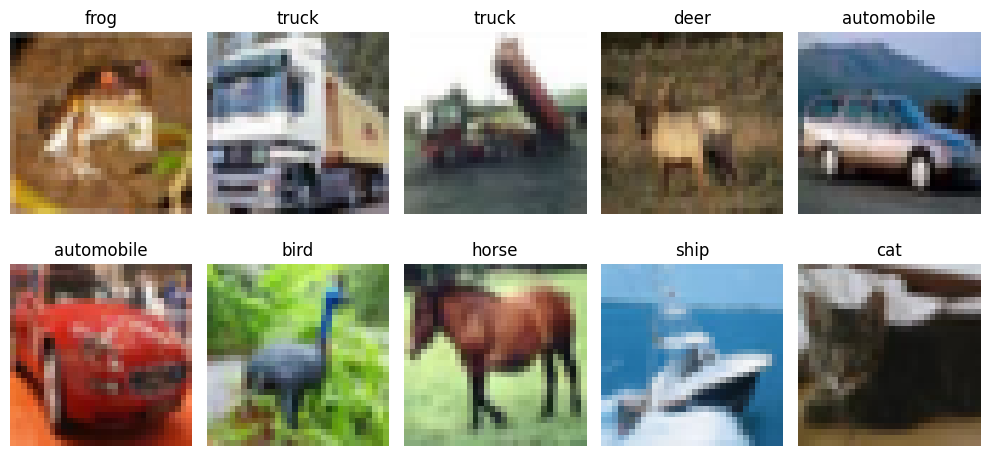

In [87]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    # Handle both (50000, 1) and (50000,) cases
    label_index = y_train[i] if np.ndim(y_train) == 1 else y_train[i][0]
    plt.title(class_names[label_index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [88]:
from sklearn.model_selection import train_test_split

y_train = y_train.flatten()
y_test = y_test.flatten()

# Normalize pixel values for all models 
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# One-hot encode labels for Neural Networks 
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Flatten images for classical models
X_train_flat = X_train_norm.reshape((X_train.shape[0], -1))
X_test_flat = X_test_norm.reshape((X_test.shape[0], -1))

# 5. Subsample for classical models to prevent overload
X_small, _, y_small, _ = train_test_split(
    X_train_flat, y_train, train_size=2000, stratify=y_train, random_state=42
)
X_test_small, _, y_test_small, _ = train_test_split(
    X_test_flat, y_test, train_size=400, stratify=y_test, random_state=42
)
# Normalize images for neural networks
X_small_norm = X_small.astype("float32") / 255.0
X_test_small_norm = X_test_small.astype("float32") / 255.0

X_small_norm = X_train_norm[:2000]
y_small_cat = y_train_cat[:2000]
X_test_small_norm = X_test_norm[:400]
y_test_small_cat = y_test_cat[:400]

print("Reduced classical training shape:", X_small.shape)
print("Reduced classical test shape:", X_test_small.shape)

Reduced classical training shape: (2000, 3072)
Reduced classical test shape: (400, 3072)


In [89]:
X_small_norm.shape

(2000, 32, 32, 3)

In [90]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

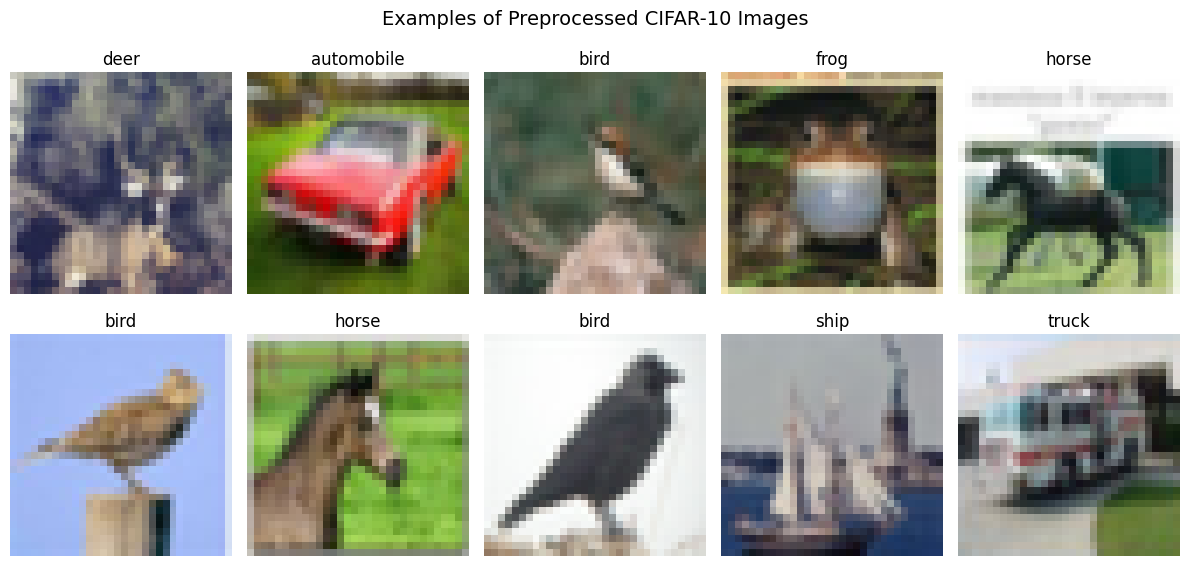

In [91]:
# Based on https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Randomly choose 10 samples
indices = np.random.choice(len(X_train), 10, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(class_names[y_train_flat[idx]])
    plt.axis('off')
plt.suptitle("Examples of Preprocessed CIFAR-10 Images", fontsize=14)
plt.tight_layout()
plt.show()

In [92]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.callbacks import EarlyStopping

# def build_mlp(hidden_units=[512, 256], dropout=0.5, lr=0.001):
#     model = Sequential()
#     model.add(Flatten(input_shape=(32,32,3)))
#     for units in hidden_units:
#         model.add(Dense(units, activation='relu'))
#         model.add(Dropout(dropout))
#     model.add(Dense(10, activation='softmax'))

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Try different configurations
# configs = [
#     {'hidden_units':[256,128], 'dropout':0.3},
#     {'hidden_units':[512,256], 'dropout':0.5},
# ]

# for cfg in configs:
#     print(f"Testing config: {cfg}")
#     mlp = build_mlp(hidden_units=cfg['hidden_units'], dropout=cfg['dropout'])
#     mlp.fit(X_train_norm, y_train_cat,
#             epochs=10,
#             batch_size=128,
#             validation_split=0.2,
#             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
#             verbose=1)
#     val_loss, val_acc = mlp.evaluate(X_test_norm, y_test_cat)
#     print("Test Accuracy:", val_acc)

In [93]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# def build_cnn(num_filters=[32,64], dense_units=128, dropout=0.5):
#     model = Sequential()
#     model.add(Conv2D(num_filters[0], (3,3), activation='relu', input_shape=(32,32,3)))
#     model.add(MaxPooling2D((2,2)))
#     model.add(Conv2D(num_filters[1], (3,3), activation='relu'))
#     model.add(MaxPooling2D((2,2)))
#     model.add(Flatten())
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(Dropout(dropout))
#     model.add(Dense(10, activation='softmax'))

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Configurations to try
# cnn_configs = [
#     {'num_filters':[32,64], 'dense_units':128, 'dropout':0.5},
#     {'num_filters':[64,128], 'dense_units':256, 'dropout':0.3},
# ]

# for cfg in cnn_configs:
#     print(f"Testing config: {cfg}")
#     cnn = build_cnn(**cfg)
#     cnn.fit(X_train_norm, y_train_cat,
#             epochs=10,
#             batch_size=128,
#             validation_split=0.2,
#             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
#             verbose=1)
#     val_loss, val_acc = cnn.evaluate(X_test_norm, y_test_cat)
#     print("Test Accuracy:", val_acc) 

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [94]:
class ClassificationModel:

    def logistic_regression(self):
        log_reg = LogisticRegression(random_state=42) 
        hyperparameter = {"model__C": [0.1, 1.0], "model__max_iter": [500, 1000]}
        return log_reg, hyperparameter
    def svm(self):
        svm = SVC(random_state=42)
        hyperparameter = {"model__C": [0.1, 1, 10], "model__kernel": ["linear", "rbf"]}
        return svm, hyperparameter
    def decision_tree(self):
        dt = DecisionTreeClassifier(random_state=42)
        hyperparameter = {"model__max_depth": [5, 10, 20, None], "model__min_samples_split": [2, 5, 10]}
        return dt, hyperparameter
    
    def random_forest(self, n_estimators = None, max_depth = None, min_samples_leaf = None, bootstrap = True):
        rf = RandomForestClassifier(random_state=42)
        hyperparameter = {"model__n_estimators":[50, 100, 200] if n_estimators == None else n_estimators,
                           "model__max_depth": [5, 10, 20, None] if max_depth == None else max_depth,
                           "model__min_samples_leaf": [2, 5, 10] if min_samples_leaf == None else min_samples_leaf,
                           "model__bootstrap": [True] if bootstrap == True else [True, False]}
        return rf, hyperparameter
    
    def ada_boost(self):
        adb = AdaBoostClassifier(random_state=42, algorithm='SAMME')
        hyperparameter = {"model__n_estimators": [50, 100], "model__learning_rate": [0.01, 0.1]}
        return adb, hyperparameter
    
    def gradient_boost(self):
        gb = GradientBoostingClassifier(random_state=42)
        hyperparameter = {
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [1, 3]
        }
        return gb, hyperparameter
    
    def bagging(self):
        bag = BaggingClassifier()
        hyperparameter = {"model__n_estimators": [50, 100]}
        return bag, hyperparameter
    
    def naivebayes(self):
        nb = GaussianNB()
        hyperparameter = {}
        return nb, hyperparameter
    
    def cnn(self):
        cnn = Sequential([
            # --- Block 1 ---
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            # --- Block 2 ---
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            # --- Flatten + Dense Layers ---
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(10, activation='softmax')
        ])
        return cnn
    
    def mlp(self, learning_rate, X_train, y_train, x_test, y_test, epoch, batch_size, verbose):
        mlp_best_acc = 0
        mlp_best_params = {}

        for hidden1 in [256, 512]:
            for hidden2 in [128, 256]:
                for dropout_rate in [0.3, 0.5]:
                    mlp = Sequential([
                        Flatten(input_shape=(32,32,3)),
                        # First Hidden Layer
                        Dense(hidden1, activation='relu'),
                        # Regularize first layer to reduce overfitting
                        Dropout(dropout_rate),
                        # Learn higher-level, more abstract features
                        Dense(hidden2, activation='relu'),
                        # Regularize second layer
                        Dropout(dropout_rate),
                        # Output layer for 10-class classification
                        Dense(10, activation='softmax')
                    ])
                    mlp.compile(optimizer=Adam(learning_rate=learning_rate),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
                    
                    mlp.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=verbose)
                    acc = mlp.evaluate(x_test, y_test, verbose=verbose)[1]
                    
                    if acc > mlp_best_acc:
                        mlp_best_acc = acc
                        mlp_best_params = {"hidden1": hidden1, "hidden2": hidden2, "dropout": dropout_rate}

        return mlp_best_params, mlp_best_acc
    
    def run_model(self, model,
               X_train, y_train,
               X_test, y_test,
               use_pca=False, n_components=0.95,
               verbose=1):
        """
        Train and evaluate a single model (optionally with PCA), without hyperparameter tuning.

        Args:
            model: sklearn estimator
            X_train, y_train: training data
            X_test, y_test: testing data
            use_pca (bool): whether to apply PCA
            n_components (float or int): PCA components (variance or count)
            verbose (int): verbosity level

        Returns:
            best_model: trained pipeline
            test_acc: test accuracy
        """

        # --- Step 1: Build pipeline ---
        steps = []
        if use_pca:
            steps.append(("reduce", PCA(n_components=n_components)))
        steps.append(("model", model))
        pipe = Pipeline(steps)

        # --- Step 2: Train the model ---
        pipe.fit(X_train, y_train)

        # --- Step 3: Evaluate ---
        test_acc = accuracy_score(y_test, pipe.predict(X_test))
        if verbose:
            print(f"Model trained. Test Accuracy = {test_acc:.4f}")

        return pipe, test_acc
    
    def tune_model(self, model, param_grid,
               X_train, y_train,
               X_test, y_test,
               use_pca=False, n_components=0.95,
               cv_folds=10, verbose=1):
        """
        Train/tune a single model (optionally with PCA) using GridSearchCV.

        Args:
            model: sklearn estimator
            param_grid (dict): grid for GridSearchCV (can be empty for no tuning)
            X_train, y_train: training data
            X_test, y_test: testing data
            use_pca (bool): whether to apply PCA
            n_components (float or int): PCA components (variance or count)
            cv_folds (int): number of CV folds
            verbose (int): verbosity level

        Returns:
            best_model: trained pipeline (best estimator)
            test_acc: test accuracy
        """

        # --- Step 1: Build pipeline ---
        steps = []
        if use_pca:
            steps.append(("reduce", PCA(n_components=n_components)))
        steps.append(("model", model))
        pipe = Pipeline(steps)

        # --- Step 2: Check if tuning is needed ---
        if not param_grid:
            pipe.fit(X_train, y_train)
            acc = accuracy_score(y_test, pipe.predict(X_test))
            print(f"Model trained without tuning. Test Accuracy = {acc:.4f}")
            return pipe, acc

        # --- Step 3: GridSearchCV ---
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=cv_folds,
            n_jobs=-1,
            scoring="accuracy",
            verbose=verbose
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        # --- Step 4: Evaluate ---
        test_acc = accuracy_score(y_test, best_model.predict(X_test))
        print(f"Best Params = {search.best_params_}, Test Accuracy = {test_acc:.4f}")

        return best_model, test_acc

        
classification_model = ClassificationModel()



### Fully connected neural network

### Convolutional neural network

In [95]:
cnn = classification_model.cnn()
mlp = classification_model.mlp(learning_rate=0.01, X_train = X_small_norm, y_train=y_small_cat, x_test=X_test_small_norm, epoch=50, y_test= y_test_small_cat, batch_size=64, verbose=0)
# --- Compile Model ---
cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

cnn.summary()

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,482 (2.08 MB)

 Trainable params: 545,290 (2.08 MB)

 Non-trainable params: 192 (768.00 B)

In [96]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5)


In [97]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_small_norm, y_small_cat, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

r = cnn.fit(train_generator, 
              epochs=40,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test_small_norm, y_test_small_cat), 
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/40


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  61/1562 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.1478 - loss: 3.1005 - precision: 0.1594 - recall: 0.0420

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step - accuracy: 0.1855 - loss: 2.4989 - precision: 0.2108 - recall: 0.0271 - val_accuracy: 0.1150 - val_loss: 2.7166 - val_precision: 0.1259 - val_recall: 0.0425
Epoch 2/40
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 444us/step - accuracy: 0.2434 - loss: 2.0748 - precision: 0.4947 - recall: 0.0454 - val_accuracy: 0.1150 - val_loss: 3.8253 - val_precision: 0.1292 - val_recall: 0.1150
Epoch 3/40
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.2989 - loss: 1.9438 - precision: 0.5500 - recall: 0.0815 - val_accuracy: 0.1225 - val_loss: 4.3103 - val_precision: 0.1403 - val_recall: 0.1175
Epoch 4/40
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.3243 - loss: 1.9126 - precision: 0.5717 - recall: 0.0906 - val_accuracy: 0.1975 - val_loss: 3.1615 - val_precision: 0.2192 - val_recall: 0.1600
Epoch 5/40
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - accuracy: 0.3322 - loss: 1.8213 - precision: 0.5425 - recall: 0.1207 - val_accuracy: 0.2600 - val

In [98]:
test_loss, test_acc_cnn, test_precision, test_recall = cnn.evaluate(X_test_norm, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc_cnn:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.5182
Test Precision: 0.5945
Test Recall: 0.4410


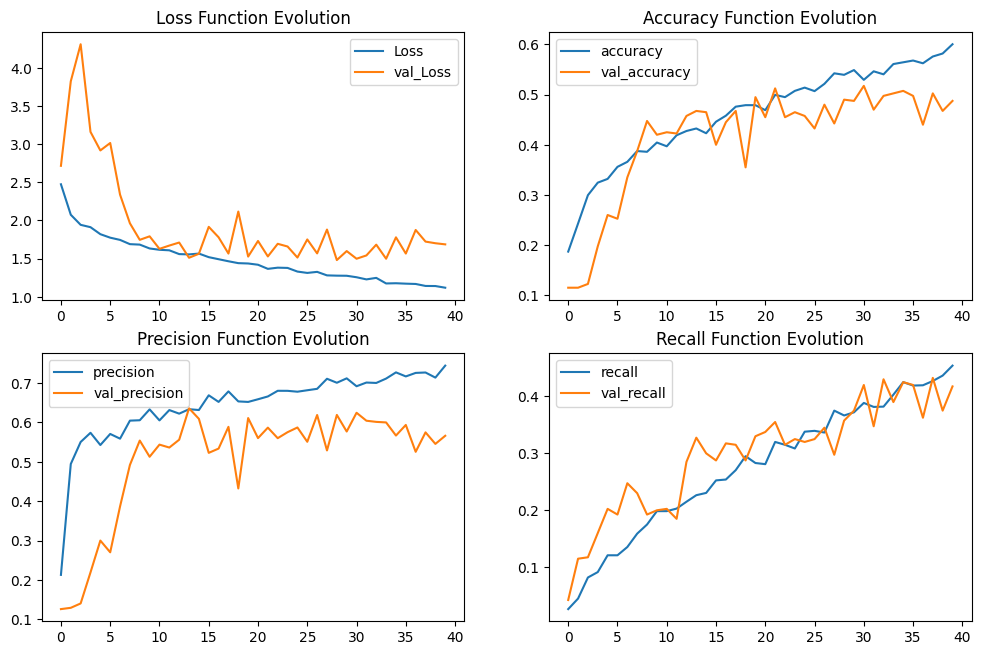

In [99]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


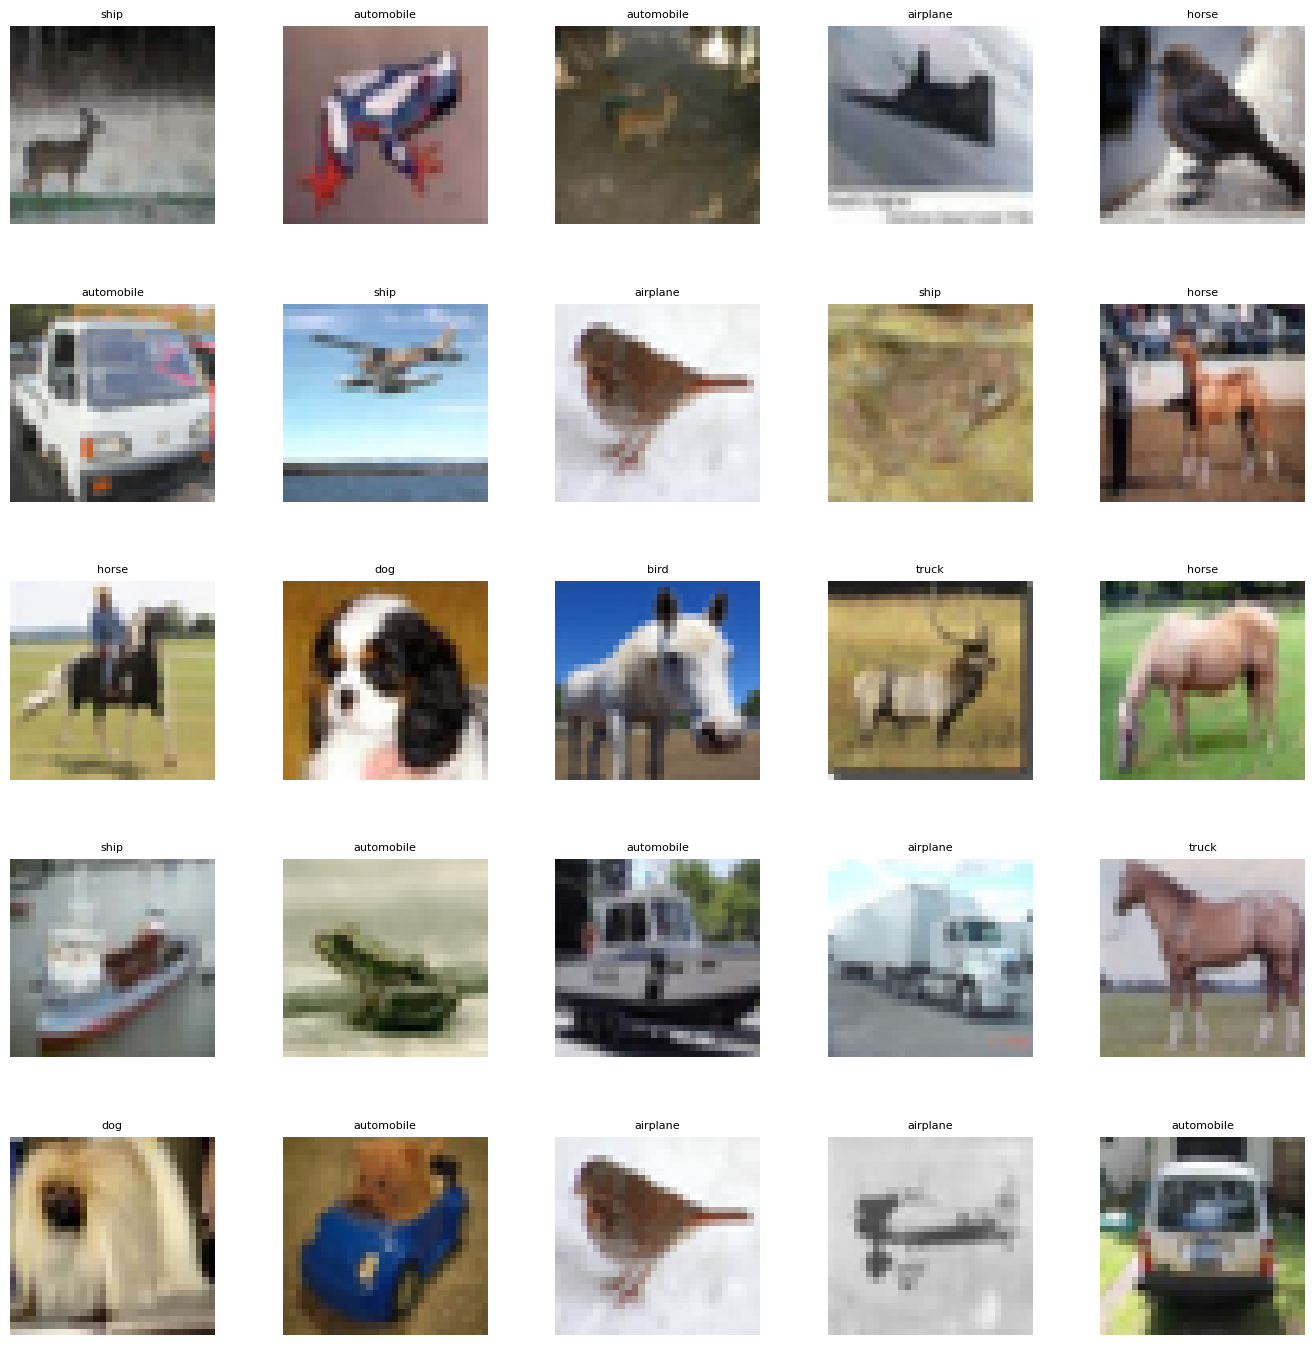

In [100]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']
y_pred = cnn.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [101]:

# Define base models
models = {
    "Logistic Regression": classification_model.logistic_regression()[0],
    "SVM": classification_model.svm()[0],
    "Decision Tree": classification_model.decision_tree()[0],
    "Random Forest": classification_model.random_forest()[0],
    "AdaBoost": classification_model.ada_boost()[0],
    "Gradient Boosting": classification_model.gradient_boost()[0],
    "Bagging": classification_model.bagging()[0],
    "Naive Bayes": classification_model.naivebayes()[0]
}

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [103]:
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="The max_iter was reached which means the coef_ did not converge")

# Parameter grids
param_grids = {
    "Logistic Regression": classification_model.logistic_regression()[1],
    "SVM": classification_model.svm()[1],
    "Decision Tree": classification_model.decision_tree()[1],
    "Random Forest": classification_model.random_forest()[1],
    "AdaBoost": classification_model.ada_boost()[1],
    "Gradient Boosting": classification_model.gradient_boost()[1],
    "Bagging": classification_model.bagging()[1],
    "Naive Bayes": classification_model.naivebayes()[1]
}

use_pca_flags = {            # maybe SVM benefits from PCA
    "Gradient Boosting": True
}

tuned_results = {}
best_models = {}

for name, model in models.items():
    print(f"\n Tuning {name}...")
    grid = param_grids.get(name, {})
    use_pca = use_pca_flags.get(name, False)
    
    pipe, test_acc = classification_model.run_model(
        model=model,
        X_train=X_small,
        y_train=y_small,
        X_test=X_test_small,
        y_test=y_test_small,
        use_pca=use_pca,
        n_components=0.95
    )

    tuned_results[name] = test_acc

print("\n🎯 Tuning complete!\n")
print(tuned_results)

print("\n🎯 All models tuned successfully!")


🔹 Tuning Logistic Regression...
Model trained. Test Accuracy = 0.2825

🔹 Tuning SVM...
Model trained. Test Accuracy = 0.4175

🔹 Tuning Decision Tree...
Model trained. Test Accuracy = 0.2300

🔹 Tuning Random Forest...
Model trained. Test Accuracy = 0.4075

🔹 Tuning AdaBoost...


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Model trained. Test Accuracy = 0.2225

🔹 Tuning Gradient Boosting...
Model trained. Test Accuracy = 0.3850

🔹 Tuning Bagging...
Model trained. Test Accuracy = 0.2925

🔹 Tuning Naive Bayes...
Model trained. Test Accuracy = 0.3150

🎯 Tuning complete!

{'Logistic Regression': 0.2825, 'SVM': 0.4175, 'Decision Tree': 0.23, 'Random Forest': 0.4075, 'AdaBoost': 0.2225, 'Gradient Boosting': 0.385, 'Bagging': 0.2925, 'Naive Bayes': 0.315}

🎯 All models tuned successfully!


In [105]:
tuned_results['CNN'] = test_acc_cnn
tuned_results['MLP'] = mlp[1]
results_df = pd.DataFrame(list(tuned_results.items()), columns=["Model", "Tuned Accuracy"])
print("\n🏁 Hyperparameter Tuning Summary:")
print(results_df)


🏁 Hyperparameter Tuning Summary:
                 Model  Tuned Accuracy
0  Logistic Regression          0.2825
1                  SVM          0.4175
2        Decision Tree          0.2300
3        Random Forest          0.4075
4             AdaBoost          0.2225
5    Gradient Boosting          0.3850
6              Bagging          0.2925
7          Naive Bayes          0.3150
8                  CNN          0.5182
9                  MLP          0.1875


In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


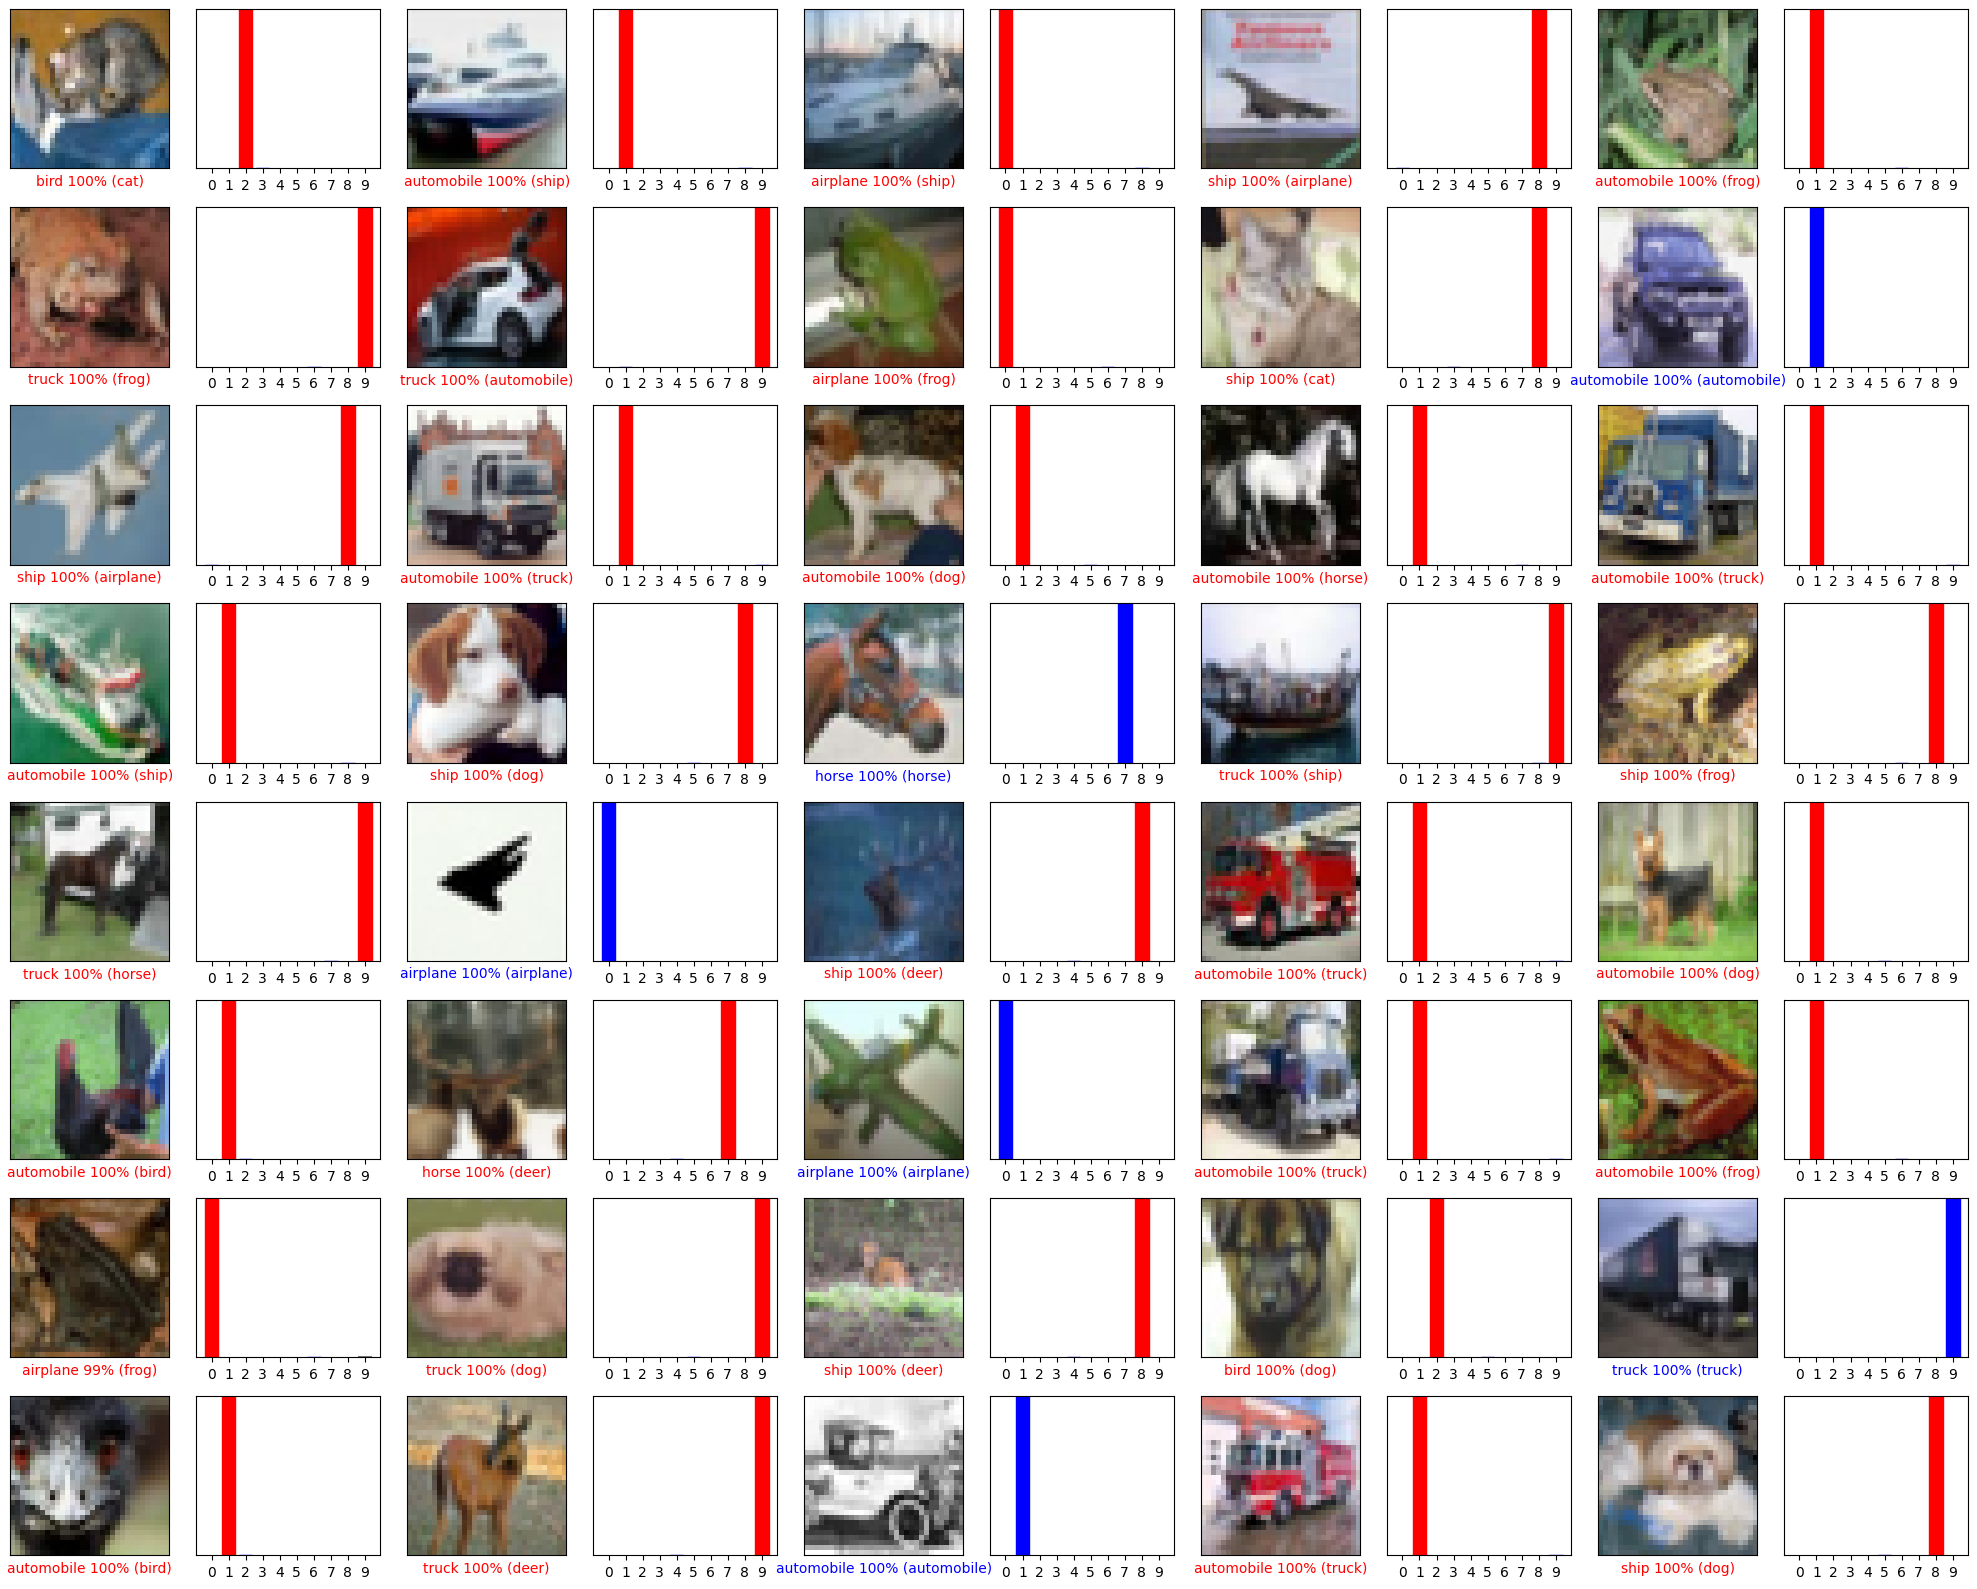

In [ ]:
predictions = cnn.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

In [ ]:
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
    X_train_flat, y_train, test_size=0.2, random_state=42
)

model_rf = classification_model.random_forest(bootstrap=False)

rf  = classification_model.tune_model(model = model_rf[0], param_grid=model_rf[1], cv_folds=10, X_train = X_train_rf, y_train = y_train_rf, X_test = X_val_rf, y_test=y_val_rf, use_pca = False)


print(f"Accuracy: {rf[1]}, Best Parameters: {rf[0]}")
# # --- Train on a subset for speed (optional) ---
# rf.fit(X_train_rf, y_train_rf)

# # --- Predict on validation set ---
# y_pred_val = rf.predict(X_val_rf)  # smaller batch for quick test

# # --- Evaluate accuracy ---
# acc = accuracy_score(y_val_rf, y_pred_val)
# print(f"Validation Accuracy: {acc:.4f}")

Fitting 10 folds for each of 12 candidates, totalling 120 fits


KeyboardInterrupt: 

In [ ]:
batch_size = 64

data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = data_generator.flow(X_train_norm, y_train_cat, batch_size=batch_size)

steps_per_epoch = X_train_norm.shape[0] // batch_size

r = cnn.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_test_norm, y_test_cat),
    verbose=1
)


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
781/781 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.4758 - loss: 1.4865 - precision: 0.6588 - recall: 0.2877 - val_accuracy: 0.6022 - val_loss: 1.1193 - val_precision: 0.7362 - val_recall: 0.4653
Epoch 2/40
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6250 - loss: 1.0779 - precision: 0.7838 - recall: 0.4531

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.6250 - loss: 1.0779 - precision: 0.7838 - recall: 0.4531 - val_accuracy: 0.5922 - val_loss: 1.1463 - val_precision: 0.7214 - val_recall: 0.4636
Epoch 3/40
781/781 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.5306 - loss: 1.3198 - precision: 0.7090 - recall: 0.3516 - val_accuracy: 0.5766 - val_loss: 1.2599 - val_precision: 0.6754 - val_recall: 0.4579
Epoch 4/40
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - accuracy: 0.6719 - loss: 1.0224 - precision: 0.8378 - recall: 0.4844 - val_accuracy: 0.5545 - val_loss: 1.3379 - val_precision: 0.6513 - val_recall: 0.4494
Epoch 5/40
781/781 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.5587 - loss: 1.2368 - precision: 0.7171 - recall: 0.3906 - val_accuracy: 0.6322 - val_loss: 1.0335 - val_precision: 0.7506 - val_recall: 0.5097
Epoch 6/40
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5000 - loss: 1.2216 - precision: 0.6774 - recall: 0.3281 - val_accuracy: 0.6274 - val_loss: 1.055

In [ ]:
test_loss, test_acc_cnn, test_precision, test_recall = cnn.evaluate(X_test_norm, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc_cnn:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.7470
Test Precision: 0.8146
Test Recall: 0.6825


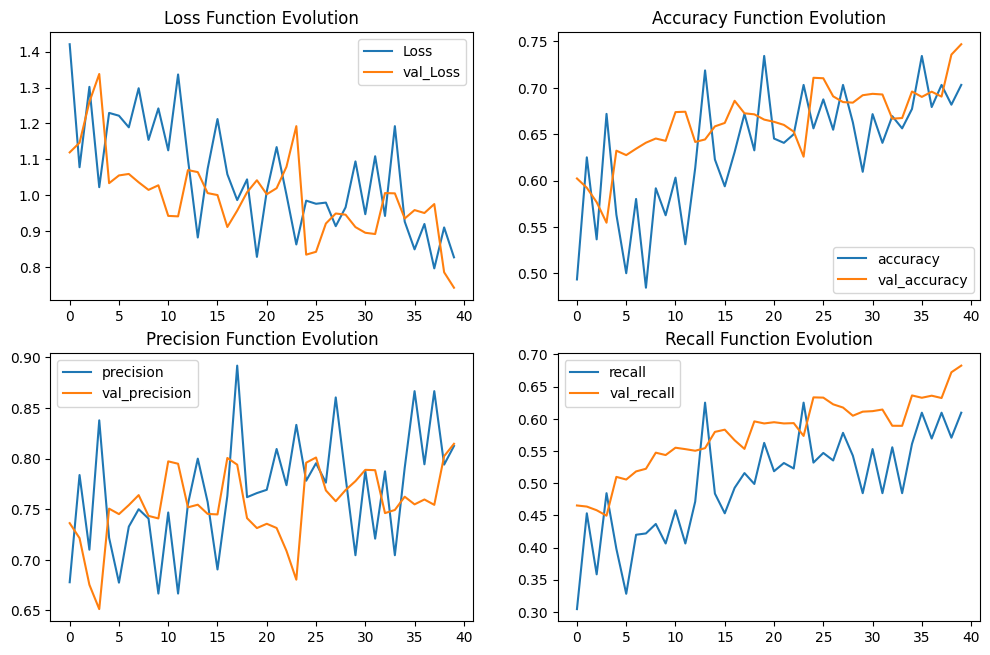

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

### Fully connected neural network

### Convolutional neural network

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network